In [1]:
import warnings
import logging
from data_loaders import load_and_merge
from forecast_helpers import ForecastConfig, setup_plot_style
from forecast_eval import backtest_forecast, naive_baseline_forecast
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scienceplots
# Suppress warnings and pandas settings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option("display.precision", 2)

# Configure logging - remove duplicate handlers and prevent propagation
logging.basicConfig(level=logging.INFO, format="%(message)s", force=True)
logger = logging.getLogger(__name__)
logger.handlers.clear()  # Clear any existing handlers
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
logger.addHandler(console_handler)
logger.propagate = False  # Prevent propagation to root logger



In [2]:
%matplotlib inline
plot_dims = setup_plot_style()

In [3]:
# Load data and define evaluation period
df = load_and_merge()
test_years = [2022, 2023, 2024]

# Model configuration
base_config = ForecastConfig(
    MAX_KNOTS_TOTAL=6,
    MAX_KNOTS_SHARES=4,
    ALPHA_TOTAL=0.005,
    TAU_YEARS=5.0,
    W_HIST_MAX=0.4,
    W_UNIF_MAX=0.2,
    MOM_TILT_MAX=0.7,
    MOM_TAU=3,
    RECENT_WIN=7,
    CAT_BOOST_SURGE=7,
    GROWTH_FLOOR_FRAC=0.07,
    SHARE_KAPPA=35,
    # from calibration_analysis.ipynb
    B_SIM=5000,                    # Increased for stability
    CONFIDENCE_LEVEL=0.90,         
    BOOTSTRAP_ITERS=500,           
    MIN_PI_WIDTH=0.2,              
    GROWTH_UNCERTAINTY_FACTOR=1,  # Calibrated value 0.686,
    YTD_YEAR=2025,
    MONOTONE_TOTALS=False,
    NO_DIP_FIRST_YEAR=False,
    NONDECREASING_CATEGORIES=False,
    ASSIMILATE_YTD=False # True for production
)

# Log configuration - modify the logging section
logger.info("\nRunning backtest with config:")
for k, v in sorted(base_config.__dict__.items()):
    if not k.startswith("_"):  # Only log public attributes
        logger.info(f"- {k}: {v}")

# Run models
model_results = backtest_forecast(df, "date", "Risk Domain", test_years, base_config)
baseline_results = naive_baseline_forecast(df, "date", test_years)


def summarize_results(results, model_name):
    """Create DataFrame summarizing model results.

    Args:
        results: List of BacktestResult objects
        model_name: Name of the model for identification

    Returns:
        DataFrame with performance metrics
    """
    return pd.DataFrame(
        {
            "Year": [r.year for r in results],
            "Actual": [r.actual for r in results],
            "Predicted": [r.predicted for r in results],
            "MAE": [r.mae for r in results],
            "MAPE": [r.mape for r in results],
            "RMSE": [r.rmse for r in results],
            "Model": model_name,
        }
    )


# Combine results
results_df = pd.concat(
    [
        summarize_results(model_results, "Main Model"),
        summarize_results(baseline_results, "Baseline"),
    ]
)






Running backtest with config:
- ALPHA_TOTAL: 0.005
- ASSIMILATE_YTD: False
- BOOTSTRAP_ITERS: 500
- B_SIM: 5000
- CAT_BOOST_SURGE: 7
- CONFIDENCE_LEVEL: 0.9
- END_YEAR: 2031
- FIRST_YEAR_CAT_MIN_INC: 1.0
- FIRST_YEAR_TOTAL_MIN_INC: 1.0
- GROWTH_FLOOR_FRAC: 0.07
- GROWTH_NB_PHI: 0.3
- GROWTH_UNCERTAINTY_FACTOR: 1
- MAX_KNOTS_SHARES: 4
- MAX_KNOTS_TOTAL: 6
- MAX_ZSCORE: 4.0
- MIN_ABS_GROWTH: 1e-06
- MIN_PI_WIDTH: 0.2
- MOM_TAU: 3
- MOM_TILT_MAX: 0.7
- MONOTONE_TOTALS: False
- NONDECREASING_CATEGORIES: False
- NO_DIP_FIRST_YEAR: False
- RANDOM_SEED: 42
- RECENT_WIN: 7
- SHARE_KAPPA: 35
- SHRINK_SURGE: 0.3
- STORE_RESIDUALS: True
- TAU_YEARS: 5.0
- W_HIST_MAX: 0.4
- W_UNIF_MAX: 0.2
- YTD_METHOD: ratio_to_average
- YTD_MIN_SHARE: 0.35
- YTD_YEAR: 2025



################################################################################
BACKTEST EVALUATION STARTING
################################################################################

Base Configuration:
- B_SIM: 5000
- RANDOM_SEED: 42
- TAU_YEARS: 5.0
- W_HIST_MAX: 0.4
- W_UNIF_MAX: 0.2
- RECENT_WIN: 7
- CAT_BOOST_SURGE: 7
- SHRINK_SURGE: 0.3
- GROWTH_FLOOR_FRAC: 0.07
- MIN_ABS_GROWTH: 1e-06
- MOM_TILT_MAX: 0.7
- MOM_TAU: 3
- MAX_KNOTS_TOTAL: 6
- MAX_KNOTS_SHARES: 4
- ALPHA_TOTAL: 0.005
- YTD_YEAR: 2025
- YTD_METHOD: ratio_to_average
- YTD_MIN_SHARE: 0.35
- FIRST_YEAR_TOTAL_MIN_INC: 1.0
- FIRST_YEAR_CAT_MIN_INC: 1.0
- SHARE_KAPPA: 35
- GROWTH_NB_PHI: 0.3
- END_YEAR: 2031
- MONOTONE_TOTALS: False
- NO_DIP_FIRST_YEAR: False
- NONDECREASING_CATEGORIES: False
- ASSIMILATE_YTD: False
- CONFIDENCE_LEVEL: 0.9
- BOOTSTRAP_ITERS: 500
- MIN_PI_WIDTH: 0.2
- GROWTH_UNCERTAINTY_FACTOR: 1
- STORE_RESIDUALS: True
- MAX_ZSCORE: 4.0

Processing test year: 2022

Data splits:
Training data: 407

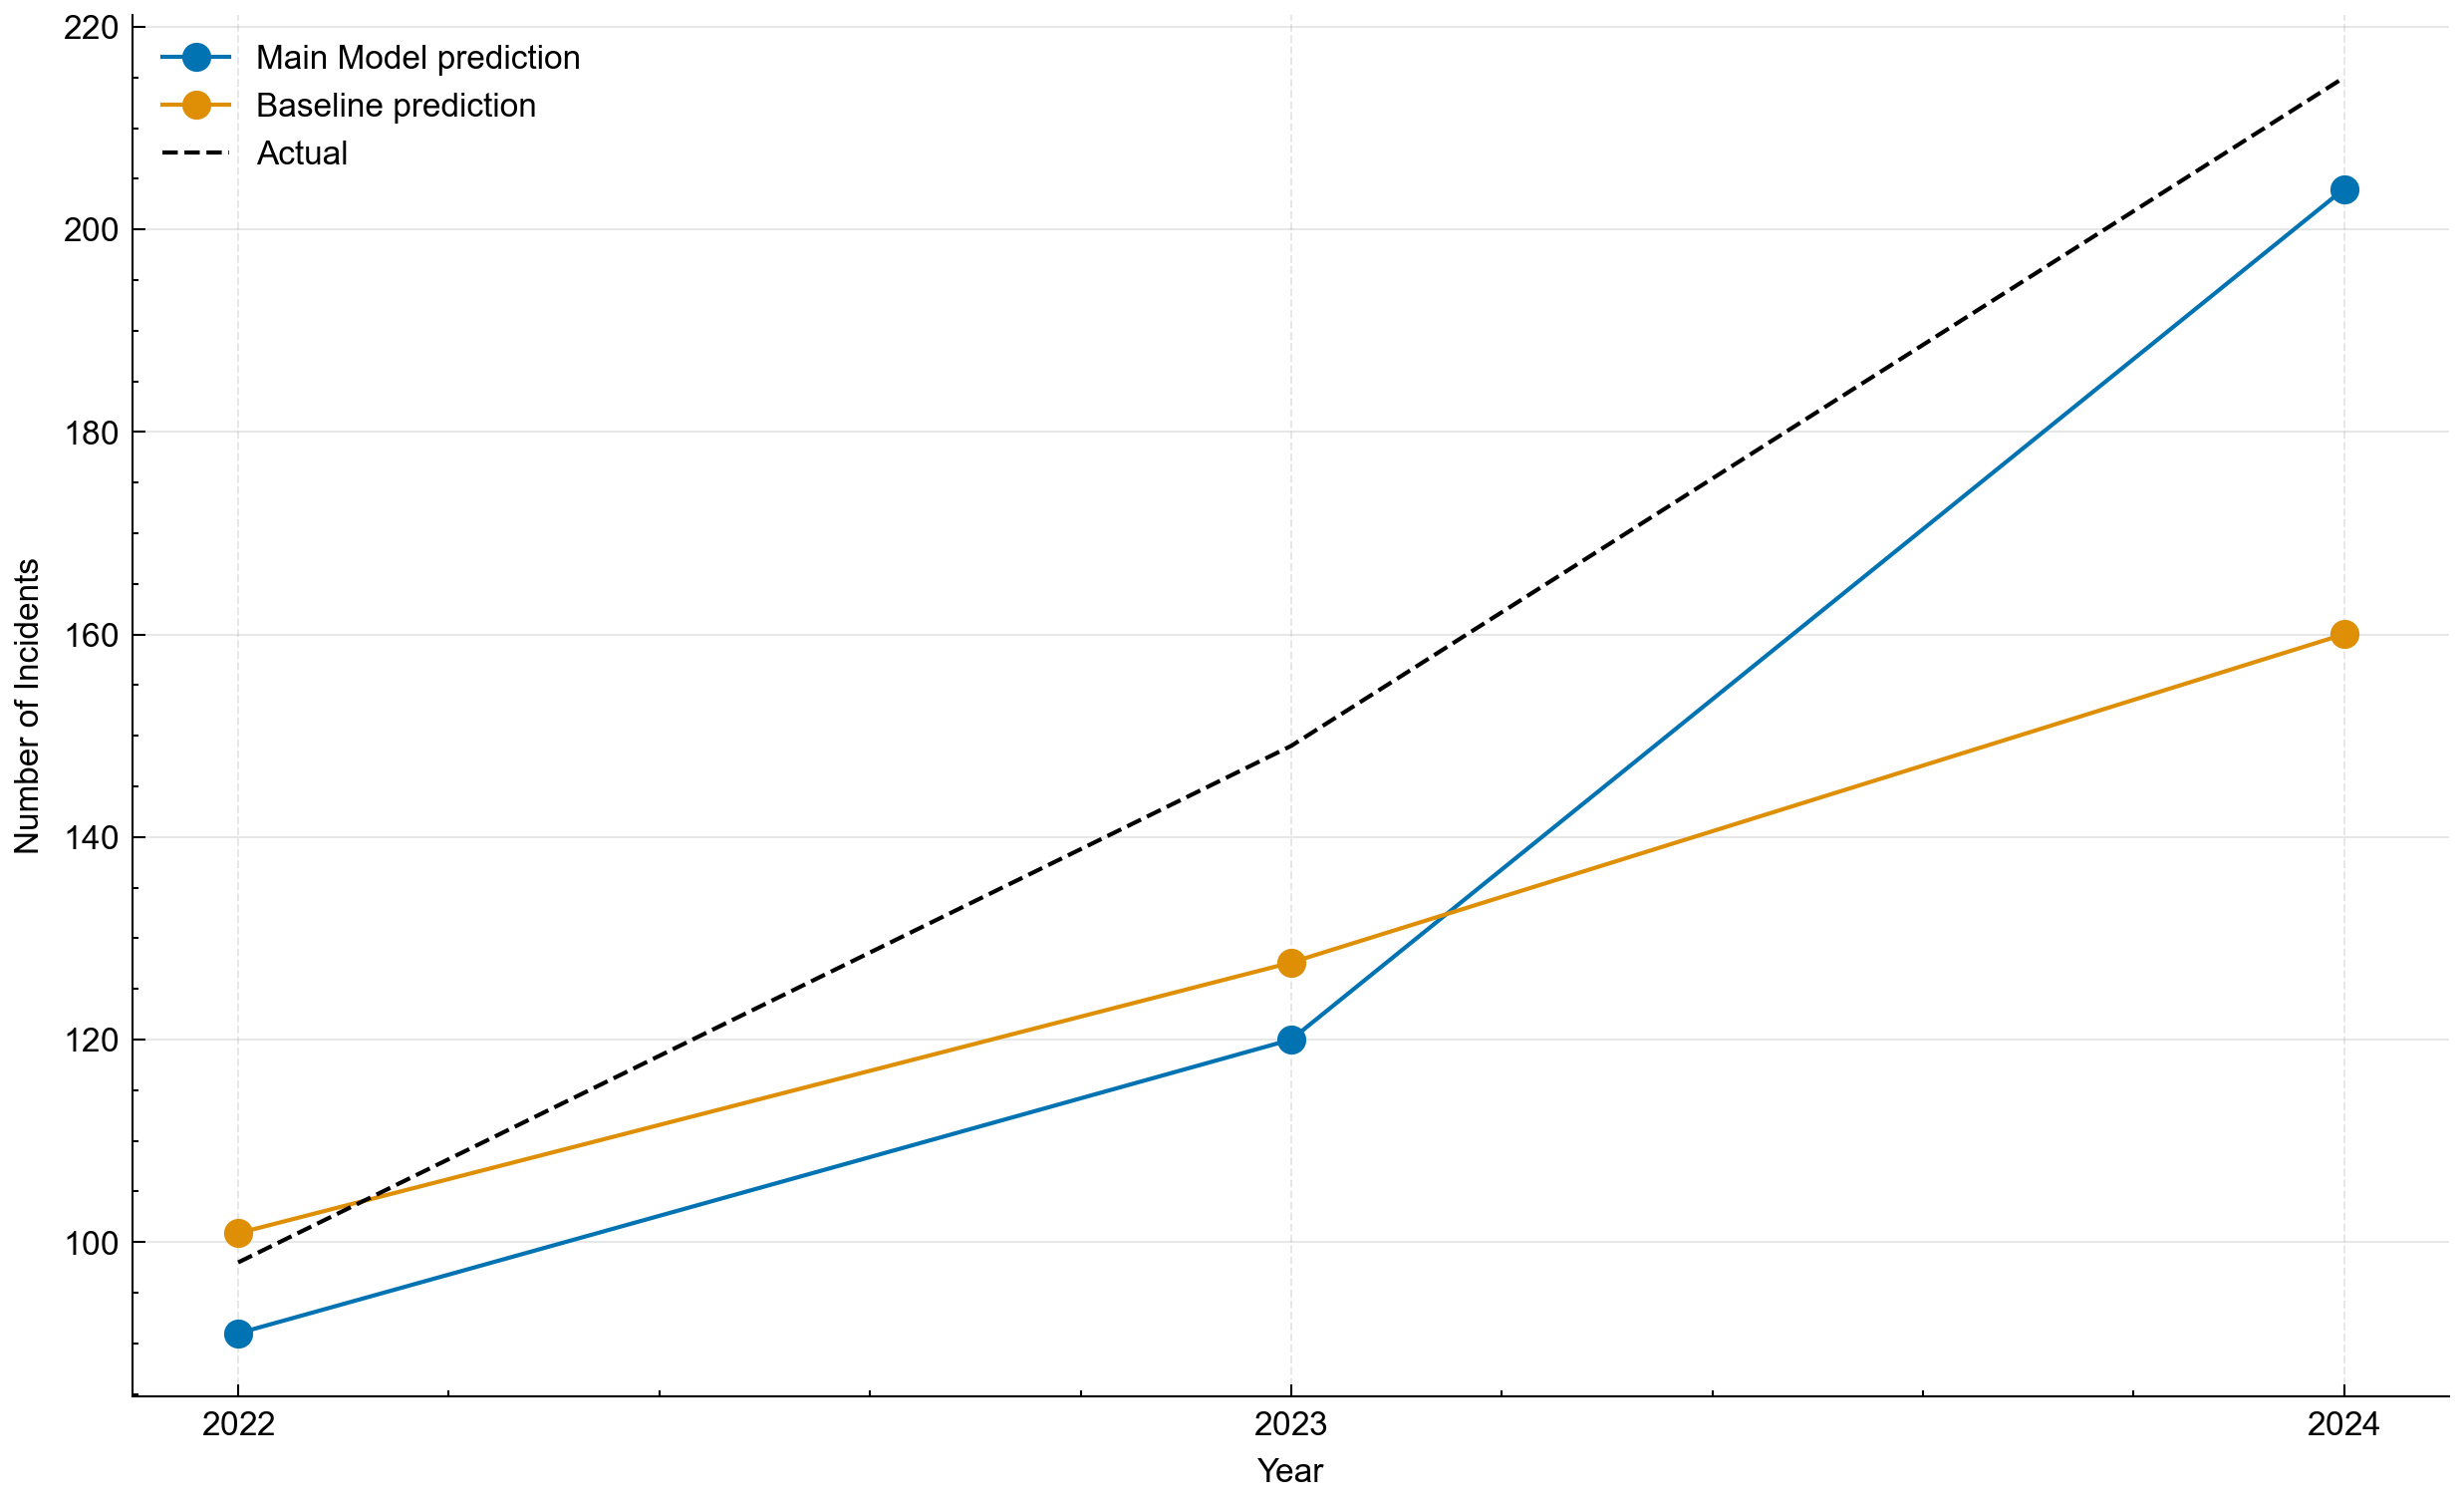

In [4]:
# Visualization
plt.figure(figsize=(10, 6))
for model in ["Main Model", "Baseline"]:
    mask = results_df["Model"] == model
    plt.plot(
        results_df[mask]["Year"],
        results_df[mask]["Predicted"],
        "o-",
        label=f"{model} prediction",
    )
plt.plot(
    results_df["Year"].unique(),
    results_df[results_df["Model"] == "Main Model"]["Actual"],
    "k--",
    label="Actual",
)
plt.xticks(test_years)  # Set xticks to only show test years
plt.tick_params(axis="x", which="both", bottom=True, top=False)
plt.grid(axis="x", alpha=0.5, linestyle="--")
plt.legend()
plt.ylabel("Number of Incidents")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# Performance summary
print("\n" + "=" * 50)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 50)

print("\nAverage Error Metrics:")
print(results_df.groupby("Model")[["MAE", "MAPE", "RMSE"]].mean())

print("\nDetailed Results by Year:")
print(results_df.sort_values(["Year", "Model"]))

# Main model error analysis
model_metrics = results_df[results_df["Model"] == "Main Model"][
    ["Year", "Actual", "Predicted"]
]
model_metrics["Error %"] = (
    (model_metrics["Predicted"] - model_metrics["Actual"])
    / model_metrics["Actual"]
    * 100
)
print("\nMain Model Yearly Errors:")
print(model_metrics.to_string(index=False))


def calculate_adaptive_metrics(results_df):
    """Calculate growth-adjusted performance metrics.

    Args:
        results_df: DataFrame containing model results

    Returns:
        float: Weighted error accounting for growth rates
    """
    main_model = results_df[results_df["Model"] == "Main Model"].copy()
    main_model["Growth_Rate"] = main_model["Actual"].pct_change()
    main_model["Weighted_Error"] = main_model["MAPE"] * (1 + main_model["Growth_Rate"])
    return main_model["Weighted_Error"].mean()


MODEL PERFORMANCE SUMMARY

Average Error Metrics:
              MAE   MAPE   RMSE
Model                          
Baseline    26.42  14.29  26.42
Main Model  15.67  10.57  15.67

Detailed Results by Year:
   Year  Actual  Predicted    MAE   MAPE   RMSE       Model
0  2022    98.0     100.89   2.89   2.95   2.89    Baseline
0  2022    98.0      91.00   7.00   7.14   7.00  Main Model
1  2023   149.0     127.61  21.39  14.36  21.39    Baseline
1  2023   149.0     120.00  29.00  19.46  29.00  Main Model
2  2024   215.0     160.03  54.97  25.57  54.97    Baseline
2  2024   215.0     204.00  11.00   5.12  11.00  Main Model

Main Model Yearly Errors:
 Year  Actual  Predicted  Error %
 2022    98.0       91.0    -7.14
 2023   149.0      120.0   -19.46
 2024   215.0      204.0    -5.12
